In [7]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [8]:
df = pd.read_csv("../../../Data/BNB-USD.csv")
df = df.sort_values("Date")
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2044 entries, 53 to 1765
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2044 non-null   object 
 1   Open       2044 non-null   float64
 2   High       2044 non-null   float64
 3   Low        2044 non-null   float64
 4   Close      2044 non-null   float64
 5   Adj Close  2044 non-null   float64
 6   Volume     2044 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 127.8+ KB


,Date,Open,High,Low,Close,Adj Close,Volume
53,1/1/2018,8.629530,8.700570,7.959220,8.414610,8.414610,66422800
418,1/1/2019,6.191432,6.191929,5.885122,6.075273,6.075273,23891162
783,1/1/2020,13.730962,13.873946,13.654942,13.689083,13.689083,172980718
1149,1/1/2021,37.374573,38.928177,37.046307,37.905010,37.905010,459165743
1514,1/1/2022,511.910370,527.352722,511.903534,527.352722,527.352722,1622547014


In [9]:
close_prices = df['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.7)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train

array([[[0.01024105],
        [0.00677112],
        [0.01806467],
        ...,
        [0.06503192],
        [0.69788348],
        [0.42345272]],

       [[0.00677112],
        [0.01806467],
        [0.05398408],
        ...,
        [0.69788348],
        [0.42345272],
        [0.01992104]],

       [[0.01806467],
        [0.05398408],
        [0.77998051],
        ...,
        [0.42345272],
        [0.01992104],
        [0.00760203]],

       ...,

       [[0.02316308],
        [1.        ],
        [0.56656827],
        ...,
        [0.45009603],
        [0.01879907],
        [0.04532121]],

       [[1.        ],
        [0.56656827],
        [0.48163036],
        ...,
        [0.01879907],
        [0.04532121],
        [0.02358458]],

       [[0.56656827],
        [0.48163036],
        [0.01640607],
        ...,
        [0.04532121],
        [0.02358458],
        [0.52015204]]])

In [10]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Build LSTM model with 50 neurons and 4 hidden layers. Using MSE loss function and Adam stochastic gradient descent optimizer.

In [11]:
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1))))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dense(1))


In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 10, epochs=100)

Epoch 1/100


138/138 [==============================] - 17s 68ms/step - loss: 0.0559
Epoch 2/100
138/138 [==============================] - 10s 73ms/step - loss: 0.0198
Epoch 3/100
138/138 [==============================] - 10s 70ms/step - loss: 0.0161
Epoch 4/100
138/138 [==============================] - 10s 74ms/step - loss: 0.0153
Epoch 5/100
138/138 [==============================] - 10s 74ms/step - loss: 0.0154
Epoch 6/100
138/138 [==============================] - 9s 68ms/step - loss: 0.0140
Epoch 7/100
138/138 [==============================] - 9s 68ms/step - loss: 0.0139
Epoch 8/100
138/138 [==============================] - 9s 68ms/step - loss: 0.0137
Epoch 9/100
138/138 [==============================] - 10s 71ms/step - loss: 0.0136
Epoch 10/100
138/138 [==============================] - 12s 90ms/step - loss: 0.0127
Epoch 11/100
138/138 [==============================] - 11s 82ms/step - loss: 0.0123
Epoch 12/100
138/138 [==============================] - 11s 82ms/step - loss: 0.0123
Epoc

In [29]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

 3/20 [===>..........................] - ETA: 0s

20/20 [==============================] - 1s 33ms/step


13.269085535561757

In [30]:
last_index = df['Close'].index.max()
next30_data = scaled_data[len(test_data)-60: , : ]
X_30 = []

for i in range(60, 60+30):
  X_30.append(test_data[i-60:i, 0])

X_30 = np.array(X_30)
X_30 = np.reshape(X_30, (X_30.shape[0], X_30.shape[1], 1))

y_30_pred = model.predict(X_30)

1/1 [==============================] - 0s 51ms/step


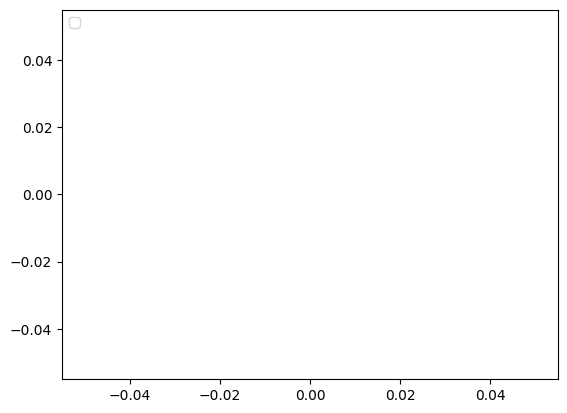

In [38]:
# data = df.filter(['Close'])
# train = data[:training_data_len]
# # validation = data[training_data_len:]
# # validation['Predictions'] = predictions
# plt.figure(figsize=(20,8))
# plt.plot(train)
# plt.plot()
# plt.title('Model')
# plt.xticks(range(0,df.shape[0],100),df['Date'].loc[::100],rotation=45)
# plt.xlabel('Date')
# plt.ylabel('Close Price USD ($)')
plt.plot(range=np.arange(start=last_index+1, stop=last_index+31), data=y_30_pred)
# plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
plt.show()

In [40]:
scaler.inverse_transform(predictions)

array([[ 1.95327312e+05],
       [ 9.95808984e+03],
       [ 1.95314512e+04],
       [ 1.05817203e+05],
       [ 2.43391547e+05],
       [ 2.09229391e+05],
       [ 1.38057156e+05],
       [ 1.96669141e+03],
       [ 2.06097852e+04],
       [ 3.56787188e+04],
       [ 2.38295344e+05],
       [ 2.14506203e+05],
       [ 1.00570391e+05],
       [ 2.40985498e+03],
       [ 1.58758135e+04],
       [ 2.03242188e+04],
       [ 2.36773156e+05],
       [ 2.16622344e+05],
       [ 7.24226484e+04],
       [-9.62439819e+02],
       [ 1.25979102e+04],
       [ 2.11212949e+04],
       [ 2.27280000e+05],
       [ 2.14130125e+05],
       [ 6.46612188e+04],
       [-4.72860596e+03],
       [ 8.29402930e+03],
       [ 1.75920449e+04],
       [ 2.57109219e+05],
       [ 2.16981047e+05],
       [ 6.73764844e+04],
       [ 5.38221289e+03],
       [ 1.45173281e+04],
       [ 2.28390938e+05],
       [ 2.14136109e+05],
       [ 7.42706592e+03],
       [ 5.55593701e+03],
       [ 3.05777539e+04],
       [ 2.4